People always look at a player's performance over the past season or several as an indicator of his skills. But how accurate is it actually at predicting the same player's performance in the new season? How many seasons back should be look? And how much the player's team can affect it? Those are the main topics this notebook aims to research.

At first, we are going to test out a simple model where we are only interested in the points (goals + assists) and, therefore, only the skaters. If the model shows any promising result, we can attempt expanding it to the other key performance indicators as well.

In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# We do not need the whole dataframe.
columns_read = ['Profile', 'Player', 'Season', 'Team', 'Year', 'Games', 'Points', 'Icetime_game_seconds']
data = pd.read_csv('../data/players/skaters_season.csv', usecols=columns_read)
data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283


We will definitely need the total time on ice over the season. After all, two players might be equally skilled but one of them simply gets much more icetime and thus gets more points. What we are going to use is not the points over the season but really a standartised amount of points over a certain interval. For ease of browse, let us set the interval as 60 minutes (standard match length) the same as with goalies.

In [2]:
data['Icetime'] = data['Games'] * data['Icetime_game_seconds'] / 3600
data['Points_average'] = data['Points'] / data['Icetime']
data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds,Icetime,Points_average
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417,1.505833,0.664084
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375,1.250000,0.000000
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360,0.800000,0.000000
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583,3.238889,1.234991
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283,0.864722,1.156441


Since we are using averages we need to ensure that all players have participated at a certain bare mininum during the season. Otherwise, their results that season are not accurate enough to base any predictions off. They are also subject to a lot of fluctuation that would end up getting accredited to other factors.

This could be accounted for in several ways, based off either games played, points scored or icetime recorded. We are going to use all three. Let us set the minimum requirement at 30 games, 10 minutes of icetime per game and 10 points.

On a related note, let us drop all playoff seasons from the data. Not only they tend to be fairly short and would be mostly sorted out based on the icetime required, but the playoff matches tend to behave somewhat differently than the regular season.

In [3]:
data = data[data['Season'] == 'Regular season']
data = data[data['Games'] >= 30]
data = data[data['Icetime_game_seconds'] >= 600]
data = data[data['Points'] >= 10]

In [4]:
data.describe()

,Games,Points,Icetime_game_seconds,Icetime,Points_average
count,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000
mean,48.821652,22.016688,1003.364622,13.674114,1.626762
std,7.585640,10.798156,173.329671,3.435627,0.661923
min,30.000000,10.000000,600.000000,5.287222,0.447094
25%,44.000000,14.000000,878.000000,11.158472,1.123944
50%,50.000000,19.000000,996.000000,13.555556,1.530128
75%,54.000000,27.000000,1119.750000,15.978472,2.016524
max,63.000000,85.000000,1720.000000,26.500000,5.162264


Important note! We have some rows where Team is specified as "Summary". That is the case when a player has changed his team during the season, so he ends up having a separate row of statistics for both teams and for them combined.

Ideally, we want to take such cases into account but it present problems of its own. If we keep just the summary, we cannot include teams in our model. If we keep the statistics for each team separately, the rows might fail the icetime requirement even if the player had enough icetime that season to get included. For now, let us go with the latter approach.

In [5]:
len(data)

4794

In [6]:
summary = data[data['Team'] == 'Summary']

In [7]:
len(summary)

459

In [8]:
data = data.groupby(['Profile', 'Year']).filter(lambda x: len(x) == 1)

In [9]:
len(data)

4298

In [10]:
data = pd.concat([data, summary])

In [11]:
len(data)

4757

In [12]:
data.groupby('Team').mean()

,Games,Points,Icetime_game_seconds,Icetime,Points_average
Team,,,,,
Admiral (Vladivostok),51.000000,20.444444,984.320988,14.031276,1.473516
Ak Bars (Kazan),49.486772,24.010582,993.349206,13.714627,1.765843
Amur (Khabarovsk),50.371429,19.335714,1015.478571,14.253639,1.378860
Atlant (Moscow Region),50.150000,23.100000,998.750000,13.984753,1.666544
Avangard (Omsk),50.072289,23.951807,1026.349398,14.354876,1.699036
Avtomobilist (Ekaterinburg),49.838235,22.110294,1012.286765,14.103270,1.579833
Barys (Nur-Sultan),50.156069,25.942197,1047.589595,14.707977,1.767115
CSKA (Moscow),47.180791,23.237288,985.310734,12.972550,1.803635
Dinamo (Minsk),48.936170,23.198582,1054.205674,14.339417,1.621045


We are going to first try predicting based off the latest two seasons that player has participated in. Important note - those seasons are not necessarily the last ones as a player could not participate in some seasons or not participate enough to be included in our analysis. And since we need the values for at least the current and two latest seasons for each player, players with less than 3 seasons in the data have to be dropped altogether.

In [13]:
data = data.groupby('Profile').filter(lambda x: len(x) > 2)

In [14]:
# To avoid typing column lists manually.
data.columns

Index(['Profile', 'Player', 'Season', 'Year', 'Team', 'Games', 'Points',
       'Icetime_game_seconds', 'Icetime', 'Points_average'],
      dtype='object')

In [15]:
# We can drop all unnecessary columns now.
drop_list = ['Season', 'Team', 'Games', 'Points', 'Icetime_game_seconds', 'Icetime']
data.drop(drop_list, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,Profile,Player,Year,Points_average
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,1.081731
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,0.965262
2,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,0.968610
3,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,1.811594
4,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,1.013514


We now need to add the year/team/points data from the past two years to the dataframe. The simplest way to do this is by adding shifted versions of the same columns with different column names. However, a row above does not necessarily contain the data for the same player. To account for that, we are going to include both past profile and player name in the output dataframe and check that they remain the same.

In [16]:
# The rows are going to be shifted down.
# All columns are getting a T_ prefix indicating their timeshift relative to the current period.
header = ['Profile', 'Player', 'Year', 'Points']
data.columns = header

data[['T1_Profile', 'T1_Points']] = data[['Profile', 'Points']].shift(-1)
data[['T2_Profile', 'T2_Points']] = data[['Profile', 'Points']].shift(-2)
data.head()

,Profile,Player,Year,Points,T1_Profile,T1_Points,T2_Profile,T2_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,1.081731,https://en.khl.ru/players/13714/,0.965262,https://en.khl.ru/players/13714/,0.968610
1,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2009/2010,0.965262,https://en.khl.ru/players/13714/,0.968610,https://en.khl.ru/players/14763/,1.811594
2,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2008/2009,0.968610,https://en.khl.ru/players/14763/,1.811594,https://en.khl.ru/players/14763/,1.013514
3,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,1.811594,https://en.khl.ru/players/14763/,1.013514,https://en.khl.ru/players/14763/,0.798509
4,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,1.013514,https://en.khl.ru/players/14763/,0.798509,https://en.khl.ru/players/14763/,0.952822


In [17]:
data.tail(5)

,Profile,Player,Year,Points,T1_Profile,T1_Points,T2_Profile,T2_Points
3849,https://en.khl.ru/players/13679/,Mikhail Zhukov,2011/2012,1.307770,https://en.khl.ru/players/13679/,1.075269,https://en.khl.ru/players/13679/,0.978648
3850,https://en.khl.ru/players/13679/,Mikhail Zhukov,2010/2011,1.075269,https://en.khl.ru/players/13679/,0.978648,https://en.khl.ru/players/18900/,0.644607
3851,https://en.khl.ru/players/13679/,Mikhail Zhukov,2009/2010,0.978648,https://en.khl.ru/players/18900/,0.644607,https://en.khl.ru/players/5714/,1.997780
3852,https://en.khl.ru/players/18900/,Artyom Zub,2016/2017,0.644607,https://en.khl.ru/players/5714/,1.997780,NaN,NaN
3853,https://en.khl.ru/players/5714/,Stanislav Zhmakin,2012/2013,1.997780,NaN,NaN,NaN,NaN


We are also encountering another issue here. Since some players have changed teams during the season, we are getting observations where the last time period our of three would be season 2009/2010. And, what is worse, some players have even played for three teams in season 2008/2009. Not only do those seasons have few observations, they are not representative as only the players who have changed teams can have either of their seasons as the latest of the three. Therefore, let us drop them.

In [18]:
# Now dropping the rows which contain data for different players in them.
data = data[(data['Profile'] == data['T1_Profile']) & (data['Profile'] == data['T2_Profile'])]
data.reset_index(drop=True, inplace=True)
data.head()

,Profile,Player,Year,Points,T1_Profile,T1_Points,T2_Profile,T2_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,1.081731,https://en.khl.ru/players/13714/,0.965262,https://en.khl.ru/players/13714/,0.968610
1,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,1.811594,https://en.khl.ru/players/14763/,1.013514,https://en.khl.ru/players/14763/,0.798509
2,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,1.013514,https://en.khl.ru/players/14763/,0.798509,https://en.khl.ru/players/14763/,0.952822
3,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,0.798509,https://en.khl.ru/players/14763/,0.952822,https://en.khl.ru/players/14763/,1.061947
4,https://en.khl.ru/players/14763/,Sergei Andronov,2015/2016,0.952822,https://en.khl.ru/players/14763/,1.061947,https://en.khl.ru/players/14763/,1.159191


In [19]:
# Everything seems in order, we can drop the duplicate columns now.
data.drop(['T1_Profile', 'T2_Profile'], axis=1, inplace=True)
data.head()

,Profile,Player,Year,Points,T1_Points,T2_Points
0,https://en.khl.ru/players/13714/,Vitaly Anikeyenko,2010/2011,1.081731,0.965262,0.968610
1,https://en.khl.ru/players/14763/,Sergei Andronov,2020/2021,1.811594,1.013514,0.798509
2,https://en.khl.ru/players/14763/,Sergei Andronov,2018/2019,1.013514,0.798509,0.952822
3,https://en.khl.ru/players/14763/,Sergei Andronov,2016/2017,0.798509,0.952822,1.061947
4,https://en.khl.ru/players/14763/,Sergei Andronov,2015/2016,0.952822,1.061947,1.159191


In [20]:
# We can now get dummies for our years and teams.
dummies = data.copy()
dummies.drop(['Profile', 'Player'], axis=1, inplace=True)
dummies = pd.get_dummies(dummies, drop_first=True)
dummies.head()

,Points,T1_Points,T2_Points,Year_2011/2012,Year_2012/2013,Year_2013/2014,Year_2014/2015,Year_2015/2016,Year_2016/2017,Year_2017/2018,Year_2018/2019,Year_2019/2020,Year_2020/2021
0,1.081731,0.965262,0.968610,0,0,0,0,0,0,0,0,0,0
1,1.811594,1.013514,0.798509,0,0,0,0,0,0,0,0,0,1
2,1.013514,0.798509,0.952822,0,0,0,0,0,0,0,1,0,0
3,0.798509,0.952822,1.061947,0,0,0,0,0,1,0,0,0,0
4,0.952822,1.061947,1.159191,0,0,0,0,1,0,0,0,0,0


We can now try fitting Machine Learning models on that prepared data. Let us first start with a simple linear regression before moving to random forests and boosted trees.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# We are trying to predict how many points a player gets this new season based off everything else.
y = dummies['Points'].copy()
X = dummies.drop('Points', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

What if we just assumed the player is going to get the exact same amount of points per hour of icetime as the last season? We need something to compare our predictions with after all.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
X_test.head()

,T1_Points,T2_Points,Year_2011/2012,Year_2012/2013,Year_2013/2014,Year_2014/2015,Year_2015/2016,Year_2016/2017,Year_2017/2018,Year_2018/2019,Year_2019/2020,Year_2020/2021
1957,0.784570,1.274404,0,0,0,0,0,0,0,0,1,0
69,2.666776,2.854444,0,0,0,0,0,0,0,0,1,0
1569,1.099148,0.919916,0,0,0,0,1,0,0,0,0,0
1829,1.834650,1.257360,0,0,0,0,0,0,0,0,0,1
2061,1.340657,1.111626,0,0,0,0,0,0,1,0,0,0


In [25]:
y_pred = X_test['T1_Points']

In [26]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.3401131138844841
RMSE: 0.5831921757744046
MAE: 0.43369554694049967
R_squared: 0.2659583663658337


What if we took the average of past two seasons?

In [27]:
y_pred = (X_test['T1_Points'] + X_test['T2_Points']) / 2

In [28]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.29116910325423584
RMSE: 0.5396008740302742
MAE: 0.41088419762000866
R_squared: 0.26281835355095984


In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
linear = LinearRegression(n_jobs=-1)

In [31]:
linear.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [32]:
y_pred = linear.predict(X_test)

In [33]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.2517423381087437
RMSE: 0.5017393128993818
MAE: 0.37994372263195386
R_squared: -0.0420037039863832


In [34]:
# Getting coefficients in a more readable form.
linear_coef = pd.DataFrame(zip(X.columns, linear.coef_))
linear_coef.columns = ['Feature', 'Coefficient']
linear_coef

,Feature,Coefficient
0,T1_Points,0.434687
1,T2_Points,0.336126
2,Year_2011/2012,-0.239408
3,Year_2012/2013,-0.167032
4,Year_2013/2014,-0.239824
5,Year_2014/2015,-0.139833
6,Year_2015/2016,-0.192558
7,Year_2016/2017,-0.175809
8,Year_2017/2018,-0.090273
9,Year_2018/2019,-0.139391


We can still improve on the way coefficients are stored. After all, we have 3 sets of coefficients for three different time periods. Why not give each period its own column?

We will need to rearrange the columns for sure. More importantly, why are Period 1 year features' coefficients so high? Something is definitely not right in here.

In [35]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Predicted Points/hour')

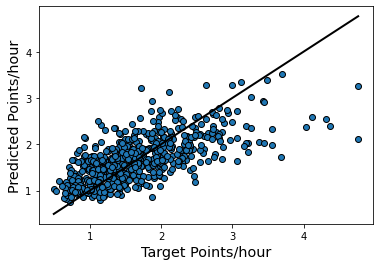

In [36]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Points/hour', size='x-large')
ax.set_ylabel('Predicted Points/hour', size='x-large')

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
forest = RandomForestRegressor(n_jobs=-1)

In [39]:
forest.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [40]:
y_pred = forest.predict(X_test)

In [41]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.27513488539062664
RMSE: 0.5245330164924098
MAE: 0.3995701507618436
R_squared: -0.08764348790927778


In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
gradient = GradientBoostingRegressor()

In [45]:
gradient.fit(X_train, y_train)

GradientBoostingRegressor()

In [46]:
y_pred = gradient.predict(X_test)

In [47]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.2518060541918944
RMSE: 0.50180280408931
MAE: 0.3788270982602972
R_squared: -0.07764776427078135


In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()

In [50]:
scaler.fit(X_train)

StandardScaler()

In [51]:
X_train_scaled = scaler.transform(X_train)

In [62]:
len(X_train_scaled)

1448

In [63]:
X_test_scaled = scaler.transform(X_test)

In [64]:
linear.fit(X_train_scaled, y_train)

LinearRegression(n_jobs=-1)

In [65]:
y_pred = linear.predict(X_test_scaled)

In [67]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.2517423381087437
RMSE: 0.5017393128993818
MAE: 0.37994372263195386
R_squared: -0.04200370398638187
